In [1]:
# Install from PyPI
#!pip install torchaudio==0.8.1 #Temporary (until pytorch 0.9 is supported in Colab)
#!pip install speechbrain
import speechbrain
import torchaudio
import numpy as np
import tensorflow

import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization, ELU, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

### Loading the data

Now I'm going to traing using MFCCs, Energy RMS and Zero Crossing.

In [3]:
# open file in read mode and read data 
filename = '../processed_data/mfccs_big_and_small.npy'
with open(filename, 'rb') as f:
    Xb = np.load(f)
    yb = np.load(f)
    Xs = np.load(f)
    ys = np.load(f)
    Xbl = np.load(f)
    ybl = np.load(f)
    Xsl = np.load(f)
    ysl = np.load(f)
# Check that we've recovered the right data
print(f'Xb:{Xb.shape}, yb:{yb.shape}')
print(f'Xs:{Xs.shape}, ys:{ys.shape}')
print(f'Xb:{Xbl.shape}, yb:{ybl.shape}')
print(f'Xs:{Xsl.shape}, ys:{ysl.shape}')

Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)
Xb:(1440, 40), yb:(1440,)
Xs:(1440, 12), ys:(1440,)


In [4]:
filename = '../processed_data/ALL40_48.npy'
with open(filename, 'rb') as f:
    ALL40_48 = np.load(f)

In [5]:
filename = '../processed_data/ZE_48.npy'
# open file in write mode and write data
with open(filename, 'rb') as f:
    Z = np.load(f)
    E = np.load(f)
    Y = np.load(f)

In [6]:
print(f'Features:{ALL40_48.shape}, Classes:{Y.shape}')

Features:(5760, 885), Classes:(5760,)


In [7]:
filename = '../processed_data/ALL40_22.npy'
with open(filename, 'rb') as f:
    ALL40_22 = np.load(f)

In [8]:
print(f'Features:{ ALL40_22 .shape}, Classes:{Y.shape}')

Features:(5760, 885), Classes:(5760,)


### 1D - Sequential Model from Literature : Choi architecture using more features!

In [9]:
model_0 = Sequential()
model_0.add(BatchNormalization(axis = 1,input_shape=(885,1), name = "batchnorm_1"))

model_0.add(Conv1D(64, 5,padding='same', name="conv1_1"))
model_0.add(ELU())
model_0.add(MaxPooling1D(pool_size=2,strides=1, padding='same'))

model_0.add(Conv1D(128, 5,padding='same', name="conv1_2"))
model_0.add(ELU())
model_0.add(MaxPooling1D(pool_size=2,strides=1, padding='same'))

model_0.add(Conv1D(128, 5,padding='same', name="conv1_3"))
model_0.add(ELU())
model_0.add(MaxPooling1D(pool_size=2,strides=1, padding='same'))


model_0.add(Conv1D(128, 5,padding='same',name="conv1_4"))
model_0.add(ELU())
model_0.add(MaxPooling1D(pool_size=4,strides=1, padding='same'))

model_0.add(Conv1D(64, 5,padding='same',name="conv1_5"))
model_0.add(ELU())
model_0.add(MaxPooling1D(pool_size=8,strides=4, padding='same'))

model_0.add(Flatten())
model_0.add(Dense(8))
model_0.add(Activation('softmax'))
opt0 = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

In [10]:
model_0.build()
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batchnorm_1 (BatchNormalizat (None, 885, 1)            3540      
_________________________________________________________________
conv1_1 (Conv1D)             (None, 885, 64)           384       
_________________________________________________________________
elu (ELU)                    (None, 885, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 885, 64)           0         
_________________________________________________________________
conv1_2 (Conv1D)             (None, 885, 128)          41088     
_________________________________________________________________
elu_1 (ELU)                  (None, 885, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 885, 128)          0

In [11]:
model_0.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt0,
              metrics=['accuracy'],weighted_metrics=['accuracy'])

In [12]:
model_0_v1 = tensorflow.keras.models.clone_model(model_0)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(ALL40_48, Y, test_size=0.20, random_state=42)

In [15]:
np.unique(y_train_b).shape

(8,)

In [16]:
cls_weights = compute_class_weight('balanced', classes = np.unique(y_train_b),y = y_train_b)

In [17]:
cls_weights

array([1.81132075, 0.93658537, 0.93658537, 0.97627119, 0.93506494,
       0.92753623, 0.93811075, 0.93053312])

In [18]:
x_traincnn_b = np.expand_dims(X_train_b, axis=2)
x_testcnn_b = np.expand_dims(X_test_b, axis=2)
y_train_b = (y_train_b - 1).astype(int)
y_test_b = (y_test_b - 1).astype(int)

In [21]:
cls_weight_dict = {0: cls_weights[0], 1: cls_weights[1], 2: cls_weights[2], 3: cls_weights[3], 4: cls_weights[4], 5: cls_weights[5], 6: cls_weights[6], 7: cls_weights[7]}
#val_sample_weights = compute_sample_weight(cls_weight_dict, y_test_b)

In [22]:
cls_weight_dict 

{0: 1.8113207547169812,
 1: 0.9365853658536586,
 2: 0.9365853658536586,
 3: 0.976271186440678,
 4: 0.935064935064935,
 5: 0.927536231884058,
 6: 0.9381107491856677,
 7: 0.9305331179321487}

In [23]:
print(x_traincnn_b.shape)

(4608, 885, 1)


In [24]:
cnnhistory=model_0.fit(x_traincnn_b, np.array(y_train_b), batch_size=32, epochs=100, validation_data=(x_testcnn_b, np.array(y_test_b)),class_weight=cls_weight_dict )

Epoch 1/100
144/144 [==============================] - 45s 307ms/step - loss: 1.7057 - accuracy: 0.3407 - weighted_accuracy: 0.3428 - val_loss: 1.8764 - val_accuracy: 0.3220 - val_weighted_accuracy: 0.3220
Epoch 2/100
144/144 [==============================] - 45s 315ms/step - loss: 1.5500 - accuracy: 0.4091 - weighted_accuracy: 0.4088 - val_loss: 1.6916 - val_accuracy: 0.3828 - val_weighted_accuracy: 0.3828
Epoch 3/100
144/144 [==============================] - 47s 330ms/step - loss: 1.4783 - accuracy: 0.4421 - weighted_accuracy: 0.4459 - val_loss: 1.5340 - val_accuracy: 0.4297 - val_weighted_accuracy: 0.4297
Epoch 4/100
144/144 [==============================] - 51s 356ms/step - loss: 1.4156 - accuracy: 0.4720 - weighted_accuracy: 0.4739 - val_loss: 1.3983 - val_accuracy: 0.4852 - val_weighted_accuracy: 0.4852
Epoch 5/100
144/144 [==============================] - 50s 347ms/step - loss: 1.3660 - accuracy: 0.4850 - weighted_accuracy: 0.4846 - val_loss: 1.3332 - val_accuracy: 0.4757 - 

**El tiempo de entrenamiento subió considerablemente con el aumento de dimensión de los vectores de entrada!**

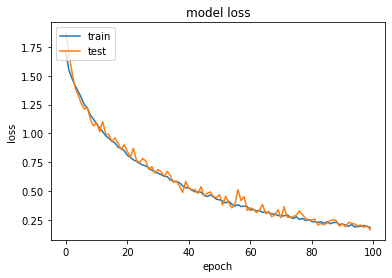

In [25]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

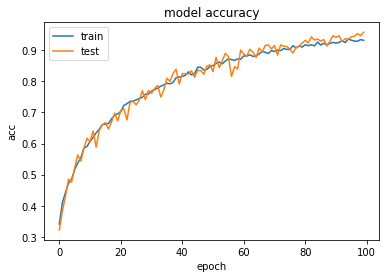

In [26]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
predictions=model_0.predict(x_testcnn_b) 
classes_x=np.argmax(predictions,axis=1)

In [28]:
from sklearn.metrics import classification_report
report = classification_report(y_test_b,classes_x)
print(report)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        66
           1       0.90      0.97      0.94       153
           2       0.99      0.95      0.97       153
           3       0.98      0.94      0.96       178
           4       1.00      0.95      0.97       152
           5       0.95      0.97      0.96       147
           6       0.97      0.95      0.96       154
           7       0.96      0.96      0.96       149

    accuracy                           0.96      1152
   macro avg       0.95      0.96      0.96      1152
weighted avg       0.96      0.96      0.96      1152



In [29]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test_b, classes_x)
print (matrix)

[[ 66   0   0   0   0   0   0   0]
 [  4 149   0   0   0   0   0   0]
 [  3   1 145   3   0   1   0   0]
 [  0   8   0 167   0   0   3   0]
 [  1   1   0   0 144   1   1   4]
 [  0   0   2   0   0 143   0   2]
 [  1   6   0   0   0   0 147   0]
 [  0   0   0   0   0   6   0 143]]


In [30]:
loss, acc = model_0.evaluate(x_testcnn_b, np.asarray(y_test_b))
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

36/36 [==============================] - 3s 96ms/step - loss: 0.1644 - accuracy: 0.9583 - weighted_accuracy: 0.9583


ValueError: too many values to unpack (expected 2)

### Why validation is lower than trainning loss?. 

An answer that I found:
    
It is difficult to be certain without knowing your actual methodology (e.g. cross-validation method, performance metric, data splitting method, etc.).

Generally speaking though, training error will almost always underestimate your validation error. However it is possible for the validation error to be less than the training. You can think of it two ways:

Your training set had many 'hard' cases to learn
Your validation set had mostly 'easy' cases to predict
That is why it is important that you really evaluate your model training methodology. If you don't split your data for training properly your results will lead to confusing, if not simply incorrect, conclusions.

I think of model evaluation in four different categories:

Underfitting – Validation and training error high

Overfitting – Validation error is high, training error low

Good fit – Validation error low, slightly higher than the training error

Unknown fit - Validation error low, training error 'high'

I say 'unknown' fit because the result is counter intuitive to how machine learning works. The essence of ML is to predict the unknown. If you are better at predicting the unknown than what you have 'learned', AFAIK the data between training and validation must be different in some way. This could mean you either need to reevaluate your data splitting method, adding more data, or possibly changing your performance metric (are you actually measuring the performance you want?).

EDIT

To address the OP's reference to a previous python lasagne question.

This suggests that you have sufficient data to not require cross-validation and simply have your training, validation, and testing data subsets. Now, if you look at the lasagne tutorial you can see that the same behavior is seen at the top of the page. I would find it hard to believe the authors would post such results if it was strange but instead of just assuming they are correct let's look further. The section of most interest to us here is in the training loop section, just above the bottom you will see how the loss parameters are calculated.

The training loss is calculated over the entire training dataset. Likewise, the validation loss is calculated over the entire validation dataset. The training set is typically at least 4 times as large as the validation (80-20). Given that the error is calculated over all samples, you could expect up to approximately 4X the loss measure of the validation set. You will notice, however, that the training loss and validation loss are approaching one another as training continues. This is intentional as if your training error begins to get lower than your validation error you would be beginning to overfit your model!!!

I hope this clarifies these errors.